# Method 1
<br>
Here, I tried a direct decomposition method to explain stock return. This method is a standard method suggested by CFA curriculum.<br>
<br>
Under the method, the stock return contains 3 parts.<br>
\--M: Market return (SP500)<br>
\--S: Industry (style) return - the difference between the return of the industry index and the market<br>
\--R: Idiosyncratic return - the difference between the return of the single name equity and the industry index<br>
In total <br>
$R_{total} = M + S + A$
<br>

Since the raw values for M,S and A might be negative. we use the variance decomposition to measure the contribution for each part and use a stacked plot to demonstrate the effect. <br>We use 4 tech stocks (namely AAPL, AMZN, MSFT, and GOOG) as our examples.<br>

In [8]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib
import math
import time
import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=5) 
matplotlib.rc('ytick', labelsize=5)

In [2]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2017, 12, 31)
NDXT = web.DataReader('^NDXT', 'yahoo',start,end)
SP500 = web.DataReader('^GSPC', 'yahoo',start,end)

In [3]:
SP500_weekly_return = SP500.resample('W-MON').last()['Close'].pct_change().fillna(0)
NDXT_weelky_return = NDXT.resample('W-MON').last()['Close'].pct_change().fillna(0)

In [4]:
def calc_pct_contribution(df):
    df_tmp = df**2
    res = df_tmp.divide(df_tmp.sum(axis = 1),axis = 0).mean()
    return res

def roll(df, w):
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array, 
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

def plot_for_techstk(syms):
    y = math.ceil(len(syms)/2)
    for i,sym in enumerate(syms):
        stkdata = web.DataReader(sym, 'yahoo',start,end)
        # May need to rerun if error raised.
        # It's due to the instability of Yahoo Finance API
        
        time.sleep(1)
        weelky_return = stkdata.resample('W-MON').last()['Adj Close'].pct_change().fillna(0)
        return_due_industry = NDXT_weelky_return - SP500_weekly_return
        return_due_stock = weelky_return - NDXT_weelky_return
        result = pd.DataFrame([SP500_weekly_return,return_due_industry,return_due_stock]).T
        result.columns = ['market','industry','stock']
        res = roll(result,12).apply(calc_pct_contribution)
        plt.figure(figsize = (16,4.5*y))
        plt.subplot(y,2,i+1)
        plt.stackplot(res.index,  res['market'],  res['industry'],  res['stock'], labels=['market','industry','stock'],
                     colors = ['#fcd4a1','#FFB6C1','#48c4b7'])
        plt.legend(loc='upper left')
        plt.margins(0,0)
        plt.title('Return Attribution for ' + sym)
    plt.show()

In each graph, the 3 part shows the contribution for each part in stock's recent return (for smoothing, I use a 3-month observaton window).<br>

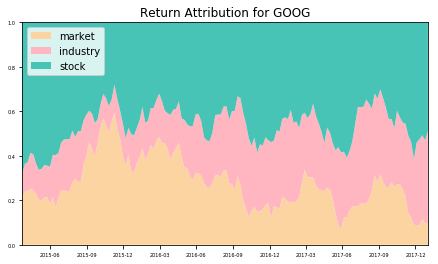

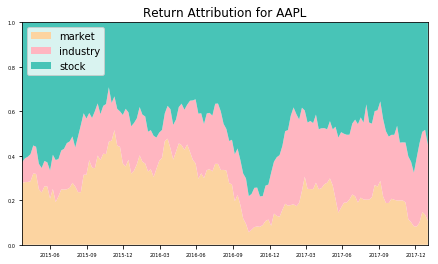

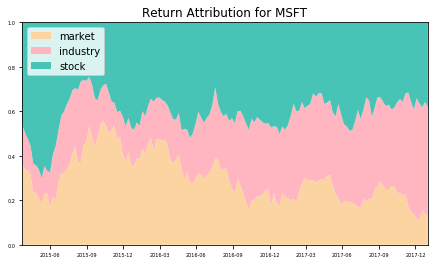

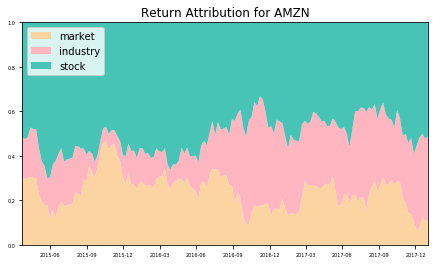

In [5]:
plot_for_techstk(['GOOG','AAPL','MSFT','AMZN'])